In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daily-temps-world-cities/Daily_temp_data_with_2020_removed.csv


In [3]:
!pip install prophet

from sklearn.metrics import mean_absolute_error as mae
from prophet import Prophet

In [4]:
!python --version

Python 3.7.12


In [3]:
# Read all the data into a DF
df_raw = pd.read_csv('/kaggle/input/daily-temps-world-cities/Daily_temp_data_with_2020_removed.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
CITY = 'San Diego'
MAX_DATE = pd.to_datetime(df_raw['date'].max())
TEST_INTERVAL_DAYS = 365

In [5]:
df = df_raw[df_raw['City'] == CITY]

# Make date into dataframe index and convert to datetime format
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
df.head()

,Region,Country,State,City,AvgTemperature,lat,lng
date,,,,,,,
1995-01-01,North America,US,California,San Diego,55.0,32.8312,-117.1225
1995-01-02,North America,US,California,San Diego,53.1,32.8312,-117.1225
1995-01-03,North America,US,California,San Diego,55.4,32.8312,-117.1225
1995-01-04,North America,US,California,San Diego,54.2,32.8312,-117.1225
1995-01-05,North America,US,California,San Diego,57.7,32.8312,-117.1225


In [6]:
# Remove any rows with AvgTemperature = -99.0
df = df[df['AvgTemperature'] != -99.0]

In [7]:
from datetime import datetime, timedelta
    
# Split data into train/test data based on test interval
split_date = MAX_DATE - timedelta(days=TEST_INTERVAL_DAYS)

df_train = df[df.index <= split_date]
df_test = df[df.index > split_date]

In [8]:
# Create a training set for Prophet
ts = pd.DataFrame({'ds':df_train.index, 'y':df_train.AvgTemperature})
ts.head()

,ds,y
date,,
1995-01-01,1995-01-01,55.0
1995-01-02,1995-01-02,53.1
1995-01-03,1995-01-03,55.4
1995-01-04,1995-01-04,54.2
1995-01-05,1995-01-05,57.7


In [9]:
# Fit Prophet instance to data and create dataframe to store future predictions
prophet = Prophet()
prophet.fit(ts)

future = prophet.make_future_dataframe(periods=TEST_INTERVAL_DAYS)
future.tail()

22:19:50 - cmdstanpy - INFO - Chain [1] start processing
22:19:54 - cmdstanpy - INFO - Chain [1] done processing


,ds
9113,2019-12-27
9114,2019-12-28
9115,2019-12-29
9116,2019-12-30
9117,2019-12-31


In [10]:
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
9113,2019-12-27,57.997989,54.173153,62.045480
9114,2019-12-28,57.930249,53.599591,61.802411
9115,2019-12-29,57.948024,54.149826,62.027666
9116,2019-12-30,58.106403,54.120876,62.497292
9117,2019-12-31,58.139160,53.881114,61.994876


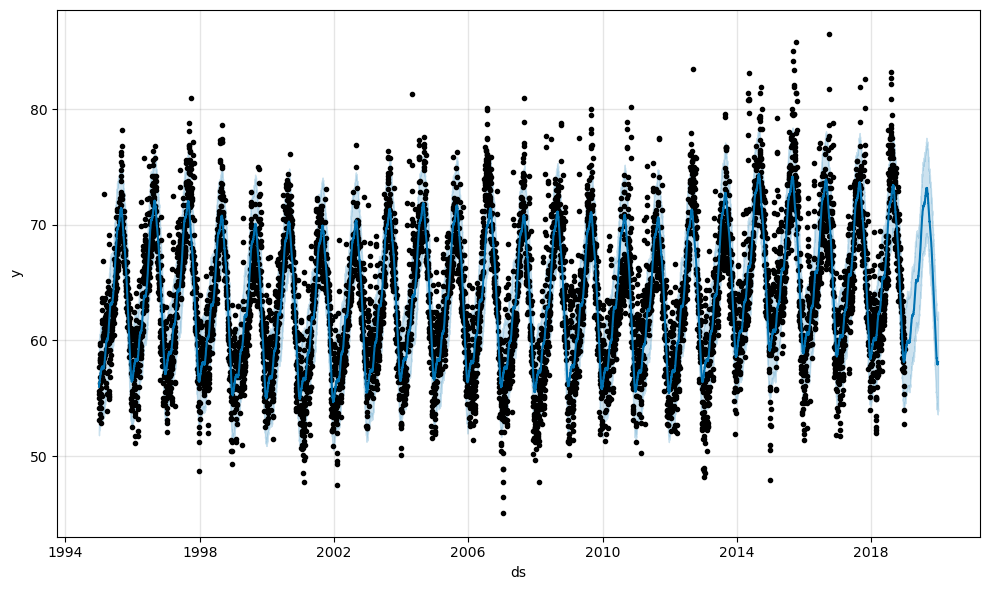

In [11]:
fig1 = prophet.plot(forecast)

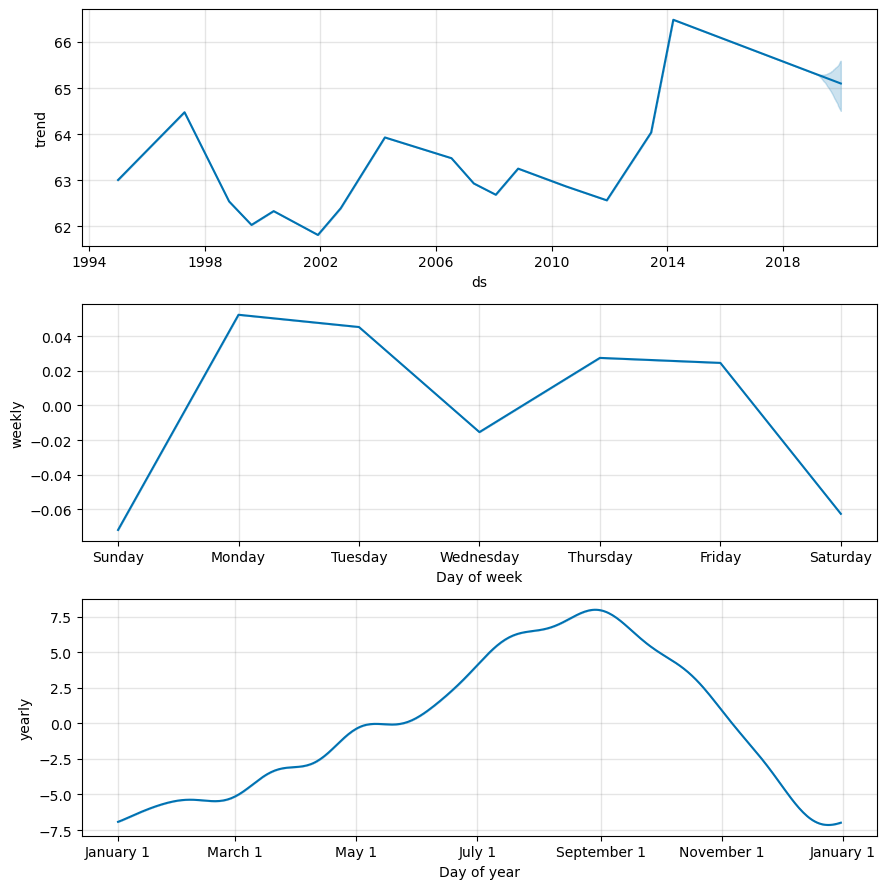

In [12]:
fig2 = prophet.plot_components(forecast)

In [13]:
from datetime import datetime

# Check for missing dates in test set. We want to remove these from the predictions as well so that actual values and predictions align
missing_dates = (pd.date_range(start=split_date + timedelta(days=1), end=MAX_DATE).difference(df_test.index))
missing_dates = missing_dates.to_list()

len(missing_dates)

0

In [14]:
# Convert date in prophet forecast to Timestamp to match test set and drop missing dates
forecast.index = forecast['ds'].apply(lambda x: pd.Timestamp(x))
predicted = forecast.drop(missing_dates)

# Grab only predictions from the test timeframe
predicted = predicted[predicted.index > split_date]
predicted = predicted['yhat'].to_list()

In [15]:
actual = df_test['AvgTemperature'].to_list()

if len(predicted) != len(actual):
    print("WARNING: Predicted dates do not correspond to test dates. This may cause error calculations to be wrong.")

In [18]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import math

# calculate MAE
error = mae(actual, predicted)
mse_error = mse(actual, predicted)
  
# display
print("Mean absolute error : " + str(error))
print("Mean squared error : " + str(mse_error))
print("Root MSE : " + str(math.sqrt(mse_error)))

Mean absolute error : 2.463831304568522
Mean squared error : 9.412781076251246
Root MSE : 3.068025599021502
